# Decision Trees

This notebook aims to explain the theory behind decision trees and how they can be implemented and interpreted. It also provides answers, with reasons, to the decision tree questions in the EMC course. The notebook is broken into 4 sections: 

* 1 Rule Prediction
* The Decision Tree Algorithm
* A Decision Tree Implementation
* EMC Questions and Answers

The "1 Rule Prediction" section explains the concept of "information entropy"; the "Decision Tree Algorithm" section explains how the algorithm uses "information entropy" to build a decision tree; the "Decision Tree Implementation" section gives a worked example of applying the algorithm and interpretting it's results. Finally, the "EMC Questions and Answers" gives answer and full explanations to the decision tree questions in the EMC course.

## "1 Rule Prediction"

Given the following data set:

In [1]:
# Reading in data using pandas
import pandas as pd
data = pd.read_csv("play_data.csv")
# displaying the data
data

,Day,Outlook,Humidity,Wind,Play
0,D1,Sunny,High,Weak,No
1,D2,Sunny,High,Strong,No
2,D3,Overcast,High,Weak,Yes
3,D4,Rain,High,Weak,Yes
4,D5,Rain,Normal,Weak,Yes
5,D6,Rain,Normal,Strong,No
6,D7,Overcast,Normal,Strong,Yes
7,D8,Sunny,High,Weak,No
8,D9,Sunny,Normal,Weak,Yes
9,D10,Rain,Normal,Weak,Yes


how do you choose just 1 feature (Outlook, Humidy or Wind) that best predicts whether to play or not?

### If you didn't have any features?

Prediction is clear if we can't use any features at all. Based purely on the output play 9/14 "yes" and 5/14 "no" we could do no better than to always predict "yes". Clearly, if the results were the other way around 5/14 "yes" and 9/14 "no", then we would predict "no" with equal confidence.

An equal split, 7/14 "yes" and 7/14 "no" would be the worst possible case, it could be thought of as the most "disordered".

Similarly, if all were "yes" or all were "no", then there would be no "disorder".

### Information Entropy

The following function has this property. It is 1 when proportion p(+) = p(-) = 0.5 and 0 when proportion p(+) = 0 or 1. So 1 for maximum disorder and 0 for no disorder.

$$H(S) = -p(+) \times \log_{2}p(+)-p(-) \times \log_{2}p(-)$$

To clarify notation, S is a set containing proportion p(+) positives and p(-) negatives. So for the "output set" play, in the data above, we have p(+) = 9/14 and p(-) = 5/14. Note, p(+) = 1 - p(-). 

A plot for p(+) between 0 and 1 confirms the function has the desired shape. Note there is "computational glitch" for p(+) = 0 or p(+) = 1, I'll won't go into the explanation of this as it doesn't really help illustrate any of the ideas.

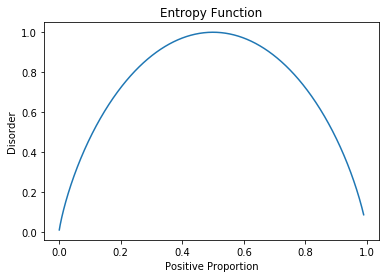

In [3]:
# importing matplotlib
import matplotlib.pyplot as plt
import numpy as np

# defining the entropy function
def HS(pp):
    pn = 1-pp
    return -pp*np.log2(pp) - pn*np.log2(pn)

# setting up a probabily variable
p_plus = np.arange(0.001,0.990,0.001)
HS_p_plus = HS(p_plus)
HS_p_plus

# plotting the entropy
plt.plot(p_plus,HS_p_plus)
plt.ylabel('Disorder')
plt.xlabel('Positive Proportion')
plt.title('Entropy Function')
plt.show()

There are plenty of other functions with a similar shape in this range. For example:

$$H(S) = 4 p(+) p(-)$$

Again this is easily verfied by a plot.

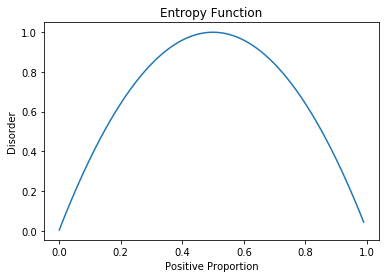

In [4]:
# importing matplotlib
import matplotlib.pyplot as plt
import numpy as np

# defining the entropy function
def HS(pp):
    pn = 1-pp
    return 4*pp*pn

# setting up a probabily variable
p_plus = np.arange(0.001,0.990,0.001)
HS_p_plus = HS(p_plus)
HS_p_plus

# plotting the entropy
plt.plot(p_plus,HS_p_plus)
plt.ylabel('Disorder')
plt.xlabel('Positive Proportion')
plt.title('Entropy Function')
plt.show()

To be used as an entropy function to measure disorder, the only real properties a function must have is to have a maximum of 1 when p(+) = 0.5 (maximum disorder) and to tail off to 0 when p(+) = 0 or 1. 

If we couldn't use any features the "disorder" of the "play set" (using the first function) would be:

In [5]:
# importing matplotlib
import numpy as np

# defining the entropy function
def HS(pp):
    pn = 1-pp
    return -pp*np.log2(pp) - pn*np.log2(pn)

pp = 9.0/14.0
HS(pp)

0.9402859586706309

### Reducing Disorder

The H(S) function above can be modified to measure the entropy of set S split by a feature F.

$$H(S,F)=\sum\limits_{\substack{f \in F}}\frac{\mid S_{f} \mid}{ \mid S \mid }H(S_{f})$$

Where $S_{f}$ is the subset of S with feature F equal to specific value f. This defintion makes sense as the maximum $H(S_{f})$ can be is 1, therefore the maximum H(S,F) can be is

$$\sum\limits_{\substack{f \in F}}\frac{\mid S_{f} \mid}{ \mid S \mid }$$

This quantity will clearly always sum to 1. The minimum $H(S,F)$ can be is 0. So $H(S,F)$ will scale between 0 and 1 as $H(S)$ does. If $H(S)$ is the disorder before splitting on feature F and $H(S,F)$ is the disorder after splitting on feature F then we can write the gain in order, $G(S,F)$, as:

$$G(S,F) = H(S) - H(S,F) = H(S) - \sum\limits_{\substack{f \in F}}\frac{\mid S_{f} \mid}{ \mid S \mid }H(S_{f})$$

### Feature Selection

A sensible strategy would be to choose the feature that maximises the gain G(S,F)

#### Gain with "Outlook"

First we need to split the data according to the each value of the Outlook feature. I.e. "Sunny", "Overcast" and "Rain"

In [6]:
# Creating logicals to split the data

SunnyBool = data['Outlook'] == 'Sunny'
OvercastBool = data['Outlook'] == 'Overcast'
RainBool = data['Outlook'] == 'Rain'

# Creating an outlook data frame
data_outlook = data[['Outlook','Play']]

# Creating data frames for "Sunny", "Overast" and "Rain"
data_Sunny = data_outlook[SunnyBool]
data_Overcast = data_outlook[OvercastBool]
data_Rain = data_outlook[RainBool]

Consider the data when the Outlook feature is equal to "Sunny"

In [7]:
data_Sunny

,Outlook,Play
0,Sunny,No
1,Sunny,No
7,Sunny,No
8,Sunny,Yes
10,Sunny,Yes


Giving $\mid S_{Sunny} \mid = 5$, $p(+) = \frac{2}{5}$ and $p(-) = \frac{3}{5}$. 

Next, consider the data when the Outlook variable is equal to "Overcast"

In [8]:
data_Overcast

,Outlook,Play
2,Overcast,Yes
6,Overcast,Yes
11,Overcast,Yes
12,Overcast,Yes


Giving $\mid S_{Overcast} \mid = 4$, $p(+) = \frac{4}{4}$ and $p(-) = \frac{0}{4}$. 

Finally, consider the data when the Outlook variable is equal to "Rain"

In [9]:
data_Rain

,Outlook,Play
3,Rain,Yes
4,Rain,Yes
5,Rain,No
9,Rain,Yes
13,Rain,No


Giving $\mid S_{Rain} \mid = 5$, $p(+) = \frac{3}{5}$ and $p(-) = \frac{2}{5}$. 

Putting everything together to calculate the gain gives:

In [10]:
# From the data above
F = ['Sunny','Overcast','Rain']
Sf = [5,4,5]
# Note 0.99999999999 used as log(0) is not defined
p_plus = [2.0/5.0,0.9999999999,3.0/5.0]

# Calculating H(S,F) and gain
pp = 9.0/14.0
HSF = 0.0
S = 14.0

for ind,f in enumerate(F):
    HSF = HSF + (Sf[ind]/S)*HS(p_plus[ind])
    
gain_Outlook = HS(pp)-HSF
gain_Outlook

0.24674981878409685

#### Gain with "Humidity"

Repeating the process for the Humidity feature

In [11]:
# Creating logicals to split the data
NormalBool = data['Humidity'] == 'Normal'
HighBool = data['Humidity'] == 'High'

# Creating an outlook data frame
data_humidity = data[['Humidity','Play']]

# Creating data frames for "Normal","High"
data_Normal = data_humidity[NormalBool]
data_High = data_humidity[HighBool]

Humidity feature equal to "Normal"

In [12]:
data_Normal

,Humidity,Play
4,Normal,Yes
5,Normal,No
6,Normal,Yes
8,Normal,Yes
9,Normal,Yes
10,Normal,Yes
12,Normal,Yes


Giving $\mid S_{Normal} \mid = 7$, $p(+) = \frac{6}{7}$ and $p(-) = \frac{1}{7}$. 

Humidity feature equal to high

In [13]:
data_High

,Humidity,Play
0,High,No
1,High,No
2,High,Yes
3,High,Yes
7,High,No
11,High,Yes
13,High,No


Giving $\mid S_{High} \mid = 7$, $p(+) = \frac{3}{7}$ and $p(-) = \frac{4}{7}$. 

In [14]:
# From the data above
F = ['Normal','High']
Sf = [7,7]
# Note 0.99999999999 used as log(0) is not defined
p_plus = [6.0/7.0,3.0/7.0]

# Calculating H(S,F) and gain
pp = 9.0/14.0
HSF = 0.0

for ind,f in enumerate(F):
    HSF = HSF + (Sf[ind]/S)*HS(p_plus[ind])
    
gain_Humidity = HS(pp)-HSF
gain_Humidity

0.15183550136234136

#### Gain with "Wind"

Repeating the process for the Wind feature

In [15]:
# Creating logicals to split the data
WeakBool = data['Wind'] == 'Weak'
StrongBool = data['Wind'] == 'Strong'

# Creating an outlook data frame
data_wind = data[['Wind','Play']]

# Creating data frames for "Normal","High"
data_Weak = data_wind[WeakBool]
data_Strong = data_wind[StrongBool]

Wind feature equal to Weak

In [16]:
data_Weak

,Wind,Play
0,Weak,No
2,Weak,Yes
3,Weak,Yes
4,Weak,Yes
7,Weak,No
8,Weak,Yes
9,Weak,Yes
12,Weak,Yes


Giving $\mid S_{Weak} \mid = 8$, $p(+) = \frac{6}{8}$ and $p(-) = \frac{2}{8}$.

Wind feature equal to Strong

In [17]:
data_Strong

,Wind,Play
1,Strong,No
5,Strong,No
6,Strong,Yes
10,Strong,Yes
11,Strong,Yes
13,Strong,No


Giving $\mid S_{Strong} \mid = 6$, $p(+) = \frac{3}{6}$ and $p(-) = \frac{3}{6}$.

In [18]:
# From the data above
F = ['Weak','Strong']
Sf = [8,6]
# Note 0.99999999999 used as log(0) is not defined
p_plus = [6.0/8.0,3.0/6.0]

# Calculating H(S,F) and gain
pp = 9.0/14.0
HSF = 0.0

for ind,f in enumerate(F):
    HSF = HSF + (Sf[ind]/S)*HS(p_plus[ind])
    
gain_Wind = HS(pp)-HSF
gain_Wind

0.04812703040826927

Looking at the gain values again:

In [19]:
gain_Outlook

0.24674981878409685

In [20]:
gain_Humidity

0.15183550136234136

In [21]:
gain_Wind

0.04812703040826927

In [22]:
data

,Day,Outlook,Humidity,Wind,Play
0,D1,Sunny,High,Weak,No
1,D2,Sunny,High,Strong,No
2,D3,Overcast,High,Weak,Yes
3,D4,Rain,High,Weak,Yes
4,D5,Rain,Normal,Weak,Yes
5,D6,Rain,Normal,Strong,No
6,D7,Overcast,Normal,Strong,Yes
7,D8,Sunny,High,Weak,No
8,D9,Sunny,Normal,Weak,Yes
9,D10,Rain,Normal,Weak,Yes


This rule gets D6, D9, D11 and D14 wrong, giving a training set accuracy of $\frac{10}{14}$, which is slightly better than the just predicting "yes" for every item on the training set, which had an accuracy of $\frac{9}{14}$

So we gain maximum information by splitting on the "Outlook" feature. The prediction rules we should use are:

* Outlook equals Sunny then play = "no"
* Outlook equals Overcast then play = "yes"
* Outlook equals Rain then play = "yes"

Looking back at the original data set

## The Decision Tree Algorithm

"1 Rule" prediction is actually the first step in the decision tree algorithm. If we were to employ this algorithm on the data set above, the first thing it would do is split the data using on the Outlook feature, as above. The next step would be to repeat this process for each of the subsets the first split produces. This process is then reiterated. Victor Lavrenko gives an explanation of this process in his [youtube playlist](https://youtu.be/eKD5gxPPeY0?list=PLBv09BD7ez_4temBw7vLA19p3tdQH6FYO). The code below demonstrates an implementation of the decision tree algorithm with the data set above using sci-kit learn. 

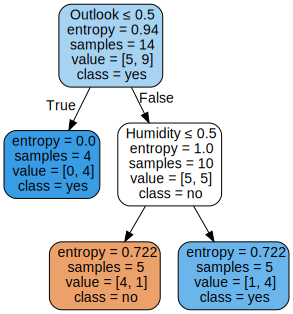

In [23]:
from sklearn.datasets import load_iris
from sklearn import tree, preprocessing

# Preprocessing to to make "labels numbers" as required by tree algorithm in scikit learn
data_transform = pd.DataFrame(columns=['Outlook','Humidity','Wind'])
le = preprocessing.LabelEncoder()
le.fit(data['Outlook'])
data_transform['Outlook'] = le.transform(data['Outlook'])
le.fit(data['Humidity'])
data_transform['Humidity']  = le.transform(data['Humidity'])
le.fit(data['Wind'])
data_transform['Wind']  = le.transform(data['Wind'])
le.fit(data['Play'])
data_play = le.transform(data['Play'])

# Fitting a decision tree
dtree = tree.DecisionTreeClassifier(max_depth=2,criterion="entropy")
dtree.fit(data_transform,data_play)

# plotting the decision tree
import graphviz
dot_data = tree.export_graphviz(dtree, 
                                out_file=None, 
                                feature_names=['Outlook','Humidity','Wind'],
                                class_names=['no','yes'],
                                filled=True, 
                                rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

The sci-kit learn decision tree algorithm seems slightly different from the algorithm Victor explains, in that it only ever splits the data into two groups. However, we can see the entropy values are what we would expect: 0.94 before the first split and then 0 and 1 in the two sets obtained from the first split. For the sets obtained from the second split we can check the entropy values are predicted inline with the entropy function defined above.

In [24]:
HS(1/5)

0.7219280948873623

In [25]:
HS(4/5)

0.7219280948873623

### Continuous Data

The decision tree algorithm can be extended to deal with continuous data, see victor lavrenko's 11th video for full details. To illustrate the idea I have included an extra temperature feature to the data above

In [26]:
# Reading in data using pandas
import pandas as pd
data = pd.read_csv("play_data_temp.csv")
# displaying the data
data

,Day,Outlook,Humidity,Wind,Temperature,Play
0,D1,Sunny,High,Weak,6,No
1,D2,Sunny,High,Strong,6,No
2,D3,Overcast,High,Weak,8,Yes
3,D4,Rain,High,Weak,10,Yes
4,D5,Rain,Normal,Weak,11,Yes
5,D6,Rain,Normal,Strong,12,No
6,D7,Overcast,Normal,Strong,20,Yes
7,D8,Sunny,High,Weak,15,No
8,D9,Sunny,Normal,Weak,30,Yes
9,D10,Rain,Normal,Weak,35,Yes


The Temperature data ranges from 5 to 35, the algorithm would step from a value of say 10 to 30 in steps of size 10, the data would then be split by thresholding with each of these values (e.g. Temperature < 10, Temperature $\geq$ 10, then Temperature < 20, Temperature $\geq$ 20 etc). The information gain for each split would be calculated and, if splitting on Temperature gave he largest information gain compared to other features, the temperature split with the largest information gain would be added to the tree. To illustrate this idea the code below splits the temperature data with a threshold of 10 and calculates the information gain for this split.

In [27]:
# Creating logicals to split the data
Less10Bool = data['Temperature'] < 10
More10Bool = data['Temperature'] >= 10

# Creating a temperature data frame
data_humidity = data[['Temperature','Play']]

# Creating data frames for "Normal","High"
dataLess10 = data_humidity[Less10Bool]
dataMore10 = data_humidity[More10Bool]

The data for less than 10 looks like

In [28]:
dataLess10

,Temperature,Play
0,6,No
1,6,No
2,8,Yes
10,5,Yes
11,7,Yes


Which has an entropy of

In [29]:
HS(3/5)

0.9709505944546686

The data for more than 10 looks like

In [30]:
dataMore10

,Temperature,Play
3,10,Yes
4,11,Yes
5,12,No
6,20,Yes
7,15,No
8,30,Yes
9,35,Yes
12,16,Yes
13,24,No


Which has an entropy of 

In [31]:
HS(6/9)

0.9182958340544896

Giving an information gain of 

In [32]:
HS(9/14) - ((5/14)*HS(3/5) + (9/14)*HS(6/9))

0.003184853044648772

Note. __The thresholding approach used by the decision tree algorithm makes a decision tree far better at dealing with data were the predictions depend on the features in a discontinuous way (e.g. Play if Temperature < 10) rather than say logistic regression where the predictions are related to the data in a continuous way, through continous functions__

## Decision Tree Implementation

The data below is taken from the [kaggle titanic competition](https://www.kaggle.com/c/titanic). The idea of the competition is to build a machine learning algorithm that best predicts whether a passenger survived or not. The first five rows of the data, the column names and the types of the columns are displayed below.

In [33]:
df = pd.read_csv("train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [34]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [35]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

A [data dictionary can be found at the kaggle website](https://www.kaggle.com/c/titanic/data). Getting useful information out of the Name, Ticket or Cabin features would, at first glance, require feature engineering, to avoid this I have reloaded the data with these columns removed. The passengerid provides no useful information, so it to has been removed also.

In [36]:
df = pd.read_csv("train.csv",usecols=['Survived','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked'])
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### Cleaning the Data

The data has been cleaned in the code below. Missing Fare and Age values have been replace by the Fare and Age mean, for the remainder of the data missing values have been replaced by the mode.

In [37]:
# Cleaning the data by "imputing" with means and modes appropirately
df['Pclass'].fillna(df['Pclass'].mode(),inplace=True)
df['Age'].fillna(df['Age'].mean(), inplace=True)
df['SibSp'].fillna(df['SibSp'].mode(),inplace=True)
df['Parch'].fillna(df['Parch'].mode(),inplace=True)
df['Fare'].fillna(df['Fare'].mean(), inplace=True)
pd.crosstab(df['Survived'], df['Sex'],margins=True)
df['Sex'].fillna('Male', inplace=True)
pd.crosstab(df['Survived'], df['Embarked'],margins=True)
df['Embarked'].fillna('S', inplace=True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### Exploratory Analysis

To get an initial feel for the predictive value of each variable the tables and plots below have been produce

#### Pclass

In [38]:
pd.crosstab(df['Survived'], df['Pclass'],margins=True)

Pclass,1,2,3,All
Survived,,,,
0,80,97,372,549
1,136,87,119,342
All,216,184,491,891


Clearly survival is effected by class

#### Sex

In [39]:
pd.crosstab(df['Survived'], df['Sex'],margins=True)

Sex,female,male,All
Survived,,,
0,81,468,549
1,233,109,342
All,314,577,891


Clearly "Sex" has a large impact on whether a passenger survived or not

#### Fare & Age

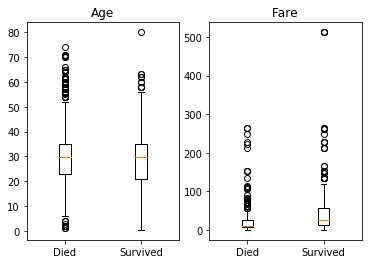

In [40]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)

axs[0].boxplot([df['Age'][df.Survived == 0],df['Age'][df.Survived == 1]])
axs[0].set_xticklabels(['Died','Survived'])
axs[0].set_title("Age")

axs[1].boxplot([df['Fare'][df.Survived == 0],df['Fare'][df.Survived == 1]])
axs[1].set_xticklabels(['Died','Survived'])
axs[1].set_title("Fare")

plt.show()

Plots would suggest neither Fare and Age have some predictive value, Fare more so than Age.

#### SibSp

In [41]:
pd.crosstab(df['Survived'], df['SibSp'],margins=True)

SibSp,0,1,2,3,4,5,8,All
Survived,,,,,,,,
0,398,97,15,12,15,5,7,549
1,210,112,13,4,3,0,0,342
All,608,209,28,16,18,5,7,891


It seems for a large value of SibSp this feature is quite predictive

#### Parch

In [42]:
pd.crosstab(df['Survived'], df['Parch'],margins=True)

Parch,0,1,2,3,4,5,6,All
Survived,,,,,,,,
0,445,53,40,2,4,4,1,549
1,233,65,40,3,0,1,0,342
All,678,118,80,5,4,5,1,891


The Parch variable seems to have some predictive power for large values and for a value of 0

#### Embarked

In [43]:
pd.crosstab(df['Survived'], df['Embarked'],margins=True)

Embarked,C,Q,S,All
Survived,,,,
0,75,47,427,549
1,93,30,219,342
All,168,77,646,891


The port of embarkation seems to have some effect on survival

### Transforming the Data

In [44]:
# as the decision tree classifier can only handle numeric data, Sex and Embarked will need to be transformed
le = preprocessing.LabelEncoder()
le.fit(df['Sex'])
df['Sex'] = le.transform(df['Sex'])
le.fit(df['Embarked'])
df['Embarked'] = le.transform(df['Embarked'])
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


The code below implements a decision tree

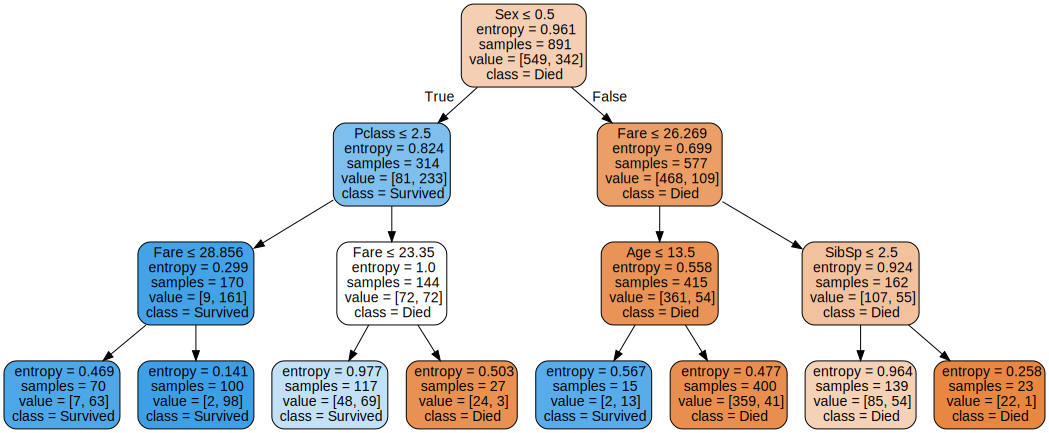

In [45]:
# Fitting a decision tree
features = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']
dtree = tree.DecisionTreeClassifier(max_depth=3,criterion="entropy")
dtree.fit(df[features],df['Survived'])

# plotting the decision tree
import graphviz
dot_data = tree.export_graphviz(dtree, 
                                out_file=None, 
                                feature_names=features,
                                class_names=['Died','Survived'],
                                filled=True, 
                                rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

A decision tree is very interprettable, as it always splits based on what gains the most information/what is most important, from top down. The following points are easily observed:

* The most important feature that determined survival on the titanic was "Sex". Female passengers were most likely to have survived and male passenger were most likely to have survived
* Given that the passenger was female, she was more likely to survive if she was first or second class and her odds increased further if she brought an expensive ticket
* A third class female passenger was equally likely to have died or survived, however her odds of survival increased if she brought a ticket with a lower fare (seems strange)
* If a passenger was male he would have been more likely to have died if he had brought a cheaper ticket, however if he brought a cheap ticket and was under 14 he was likely to survive and if he brought a cheap ticket and we over 14 he was likely to have died (seems strange)
* Of the males who brought the more expensive ticket their chances of survival increased if they had 2 or fewer siblings

# Lab

## Mandatory

* Use a calculator to verify the information gain calculations in the feature selection section
* Modify the play data set so that the feature with the largest information gain is wind
* What would be the effect of using a u shaped entropy curve?
    * Fit a quadratic that would give you the appropriate u shape
    * Repeat gain calculations with the u shape, is your prediction correct?
* Write a psuedo code implementation of the Decision Tree algorithm
* Use the data in DSBDA_code_data\Chapter 7\bank-sample data set to build a decision tree. Make sure you include an interpretation
* Go through each of the EMC questions (below) and make sure you can relate them to the theory above

## Extension

* Research the random forest method and prepare a presentation to explain the concept to your colleagues
* Can you design/lookup an entropy function for predicting a variable with 3 classes (currently there are two play or not play)

## EMC Questions and Answers

### QUESTION NO: 27

You have fit a decision tree classifier using 12 input variables. The resulting tree used 7 of the 12 variables, and is 5 levels deep. Some of the nodes contain only 3 data points. The AUC of the model is 0.85. What is your evaluation of this model?

* A. The tree is probably overfit. Try fitting shallower trees and using an ensemble method.
* B. The AUC is high, and the small nodes are all very pure. This is an accurate model.
* C. The tree did not split on all the input variables. You need a larger data set to get a more accurate model.
* D. The AUC is high, so the overall model is accurate. It is not well-calibrated, because the small nodes will give poor estimates of probability.

Answer: A

### Reason

* A - ideally you don't want nodes with a small number of items as your the resulting interpretation is less significant. In the same way a small sample size is less significant. A shallow tree would help with the small node size an ensemble method (e.g. random forest) is a standard way to improve the accuracy of a decision tree.

* B - is definitely wrong there is no mention of the purity of the nodes. (Purity is the opposite of entropy)

* C - seems a little vague, maybe the other variables are not useful in predicting

* D - is a plausible answer, I wouldn't choose it as "well-calibrated" doesn't mean much without qualification

### QUESTION NO: 142
Refer to the exhibit.

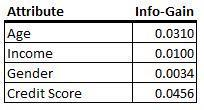

You are building a decision tree. In this exhibit, four variables are listed with their respective values of info-gain.
Based on this information, on which attribute would you expect the next split to be in the decision tree?

* A. Credit Score
* B. Age
* C. Income
* D. Gender

Answer: A

### Reason

The answer is definitely A, decision trees would by splitting on the variable that gives the highest information gain. See the 1-Rule Prediction section above for a full description of this process

### QUESTION NO: 143
Refer to the Exhibit.

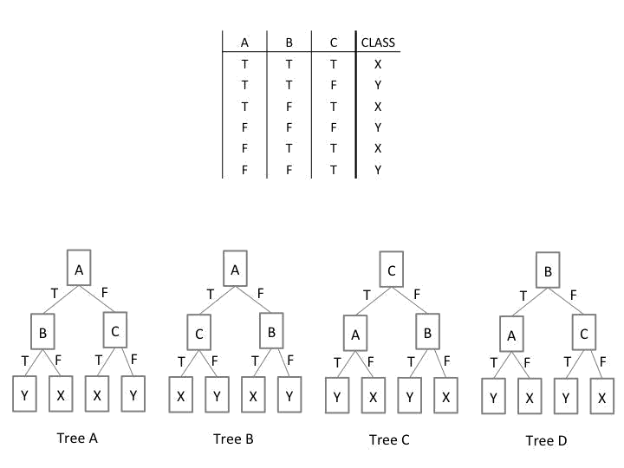

In the Exhibit, the table shows the values for the input Boolean attributes "A", "B", and "C". It also shows the values for the output attribute "class". Which decision tree is valid for the data?

* A. Tree B
* B. Tree A
* C. Tree C
* D. Tree D

Answer: A

### Reason

The answer has to be A. Work through the table and the tree together, Tree B is the only one that matches the table

### QUESTION NO: 144 (Area 4)
Refer to the Exhibit.

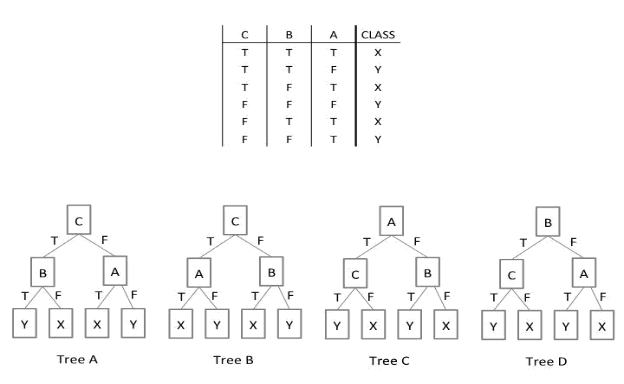

In the Exhibit, the table shows the values for the input Boolean attributes "A", "B", and "C". It also shows the values for the output attribute "class".

Which decision tree is valid for the data?

* A. Tree B
* B. Tree A
* C. Tree C
* D. Tree D

Answer: A

### Reason

The answer is A. Work through the table and the tree together, Tree B is the only one that matches the table


### QUESTION NO: 156
Refer to the exhibit.

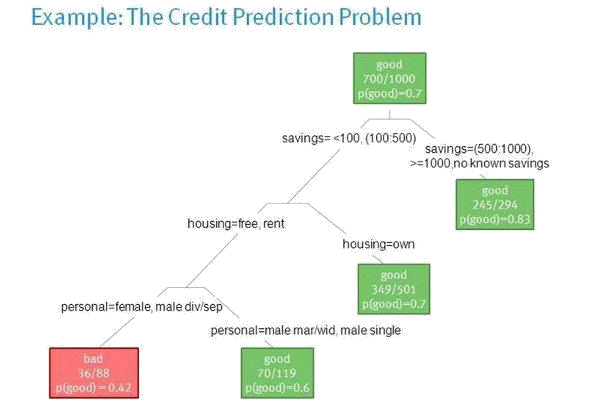

What provides the decision tree for predicting whether or not someone is a good or bad credit risk. What would be the assigned probability, p(good), of a single male with no known savings?

* A. 0.83
* B. 0
* C. 0.498
* D. 0.6

Answer: A

### Reason

The answer is A, just read the tree from top to bottom

### QUESTION NO: 157 (Area 4)

Refer to the exhibit

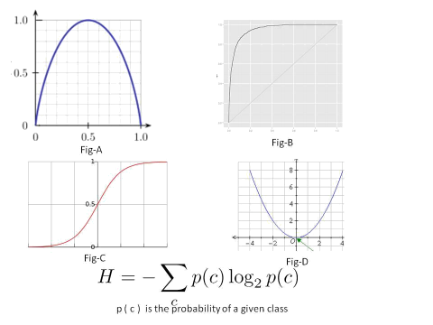

The exhibit shows four graphs labeled as Fig A thorough Fig D. Which figure represents the entropy function relative to a Boolean classification and is represented by the formula shown in Exhibit?

* A. Fig-A
* B. Fig-B
* C. Fig-C
* D. Fig-D

Answer: A

### Reason

The answer is A, it is the only figure which matches the entropy functions plotted above. Figure B is an ROC curve, figure C is the sigmoid function (used in neural nets) and figure D looks like a scaled quadratic curve.